<a href="https://colab.research.google.com/github/crisjosil/Useful_GIS_and_data_Science_scripts/blob/master/GEE_ERA5_Time_series_from_polygons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bulk Download of ERA5 climate time series data for different locations stored as polygons in shapefile

In [ ]:
import ee

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

!pip install geopandas

import geopandas as gpd
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
import numpy as np
import matplotlib.dates as mdates
import json
from scipy.signal import savgol_filter

drive.mount('/content/drive')
!ls "/content/drive/My Drive"

# Auxiliary functions

In [24]:
def simplify(fc):
    """Take a feature collection, as returned by mapping a reducer to a ImageCollection,
        and reshape it into a simpler list of dictionaries
    Args:
        fc (dict): Dictionary representation of a feature collection, as returned
            by mapping a reducer to an ImageCollection
    Returns:
        list: A list of dictionaries.
    Examples:
        >>> fc = {u'columns': {},
        ...       u'features': [{u'geometry': None,
        ...                      u'id': u'LC81970292013106',
        ...                      u'properties': {u'B1': 651.8054424353023,
        ...                                      u'B2': 676.6018246419446},
        ...                      u'type': u'Feature'},
        ...                     {u'geometry': None,
        ...                      u'id': u'LC81970292013122',
        ...                      u'properties': {u'B1': 176.99323997958842,
        ...                                      u'B2': 235.83196553144882},
        ...                      u'type': u'Feature'}]}
        >>> simplify(fc)
    """
    def feature2dict(f):
        id = f['id']
        out = f['properties']
        out.update(id=id)
        return out
    out = [feature2dict(x) for x in fc['features']]
    return out

def Time_series_of_a_region(Img_collection,geometry,stats,title,automatic_ax_lim):
    if stats == 'mean':
        fun = ee.Reducer.mean()
    elif stats == 'median':
        fun = ee.Reducer.median()
    elif stats == 'max':
        fun = ee.Reducer.max()
    elif stats == 'min':
        fun = ee.Reducer.min()
    elif stats == 'minMax':
        fun = ee.Reducer.minMax()
    else:
        raise ValueError('Unknown spatial aggregation function. Must be one of mean, median, max, or min')

    def _reduce_region(image):
                    """Spatial aggregation function for a single image and a polygon feature"""
                    #the reduction is specified by providing the reducer (ee.Reducer.mean()), the geometry  (a polygon coord), at the scale (30 meters)
                    stat_dict = image.reduceRegion(fun, geometry, 30);
                    # FEature needs to be rebuilt because the backend doesn't accept to map
                    # functions that return dictionaries
                    return ee.Feature(None, stat_dict)
    fc = Img_collection.filterBounds(geometry).map(_reduce_region).getInfo()
    out = simplify(fc)
    return(out)

# ERA5-Land hourly data collection

In [69]:
# bands to obtain data from:
date1, date2 = '2015-01-01','2023-07-31'
hour_of_day = 0
band1 = 'volumetric_soil_water_layer_1'
band2 = 'volumetric_soil_water_layer_4'
band3 = 'temperature_2m'
band4 = 'total_precipitation'
band5 = 'total_evaporation'
band6 = 'potential_evaporation'
band7 = 'snowfall'
band8= 'soil_temperature_level_1'
band9 = 'leaf_area_index_high_vegetation'
band10 = 'snow_cover'
band11 = 'evaporation_from_bare_soil'
band12 = 'evaporation_from_the_top_of_canopy'
# dataset
GEE_dataset = "ECMWF/ERA5_LAND/HOURLY"
# filter image collection
dataset = ee.ImageCollection(GEE_dataset).filter(ee.Filter.date(date1, date2)).filter(ee.Filter.eq('hour', hour_of_day)).select(band1,band2,band3,band4,
                                                                                                                                band5,band6,band7,band8,
                                                                                                                                band9,band10,band11,band12)#.select(band1,band2)#.filterBounds(geometry)


# Get time series and store as dataframe

In [70]:
# read shapefile with polygon location
shp_path = "/content/drive/My Drive/GEE_input/Loggers_locations_with_buffers.shp"
#shp_path = "/content/drive/My Drive/GEE_input/Loggers_locations.shp"
geo_df = gpd.read_file(shp_path, crs='EPSG:4326')
all_sites=np.unique(geo_df['Site'].values)

In [71]:
# Download multitemporal and multiband data for the location of each ground sensor
# Append dataframe of each ground sensor to a list
df_list=[]
for j in range(len(all_sites)):
    site=all_sites[j]
    geo_df_this_site=geo_df[geo_df['Site']==site]
    loggers_per_site = np.unique(geo_df_this_site['Logger nam'].values)
    logger=loggers_per_site[0] # select one logger for each site to get the geocoordinates of the site
    print('Site: '+site+' -  Logger: '+ logger)
    geo_df_this_site_i=geo_df_this_site[geo_df_this_site['Logger nam']==logger] #
    # Gee polygon
    geom=json.loads(geo_df_this_site_i.to_json())['features'][0]['geometry']['coordinates']
    geometry=ee.Geometry.Polygon(geom)

    #---------------------------------------- Time series of a region (image.reduceRegion) -------------------
    dataset_in_location=dataset.filterBounds(geometry)
    stats = 'mean'    #   median, max, min, minMax
    title=logger
    out=Time_series_of_a_region(dataset_in_location,geometry,stats,title,automatic_ax_lim="Yes")
    Dates=np.zeros(len(out)).tolist()
    VSWC1=np.zeros(len(out)).tolist()
    VSWC4=np.zeros(len(out)).tolist()
    Temperature=np.zeros(len(out)).tolist()
    total_precipitation=np.zeros(len(out)).tolist()
    total_evaporation=np.zeros(len(out)).tolist()
    potential_evapotranspiration=np.zeros(len(out)).tolist()
    snowfall=np.zeros(len(out)).tolist()
    soil_temp_level_1=np.zeros(len(out)).tolist()
    LAI_high=np.zeros(len(out)).tolist()
    snow_cover=np.zeros(len(out)).tolist()
    evaporation_from_bare_soil=np.zeros(len(out)).tolist()
    evaporation_from_the_top_of_canopy=np.zeros(len(out)).tolist()

    df=pd.DataFrame()
    for i in range(len(out)):
        a=out[i]['id'].split(sep='T')[0]
        Dates[i]=datetime.strptime(a, "%Y%m%d")
        VSWC1[i]=out[i]['volumetric_soil_water_layer_1']
        VSWC4[i]=out[i]['volumetric_soil_water_layer_4']
        Temperature[i]=out[i]['temperature_2m']
        total_precipitation[i]=out[i]['total_precipitation']
        total_evaporation[i]=out[i]['total_evaporation']
        potential_evapotranspiration[i]=out[i]['potential_evaporation']
        snowfall[i]=out[i]['snowfall']
        soil_temp_level_1[i]=out[i]['soil_temperature_level_1']
        LAI_high[i]=out[i]['leaf_area_index_high_vegetation']
        snow_cover[i]=out[i]['snow_cover']
        evaporation_from_bare_soil[i]=out[i]['evaporation_from_bare_soil']
        evaporation_from_the_top_of_canopy[i]=out[i]['evaporation_from_the_top_of_canopy']

    df['Dates']=Dates
    df['VSWC1']=VSWC1
    df['VSWC4']=VSWC4
    df['Temperature']=Temperature
    df['total_precipitation']=total_precipitation
    df['total_evaporation']=total_evaporation
    df['potential_evapotranspiration']=potential_evapotranspiration
    df['snowfall']=snowfall
    df['soil_temp_level_1']=soil_temp_level_1
    df['LAI_high']=LAI_high
    df['snow_cover']=snow_cover
    df['evaporation_from_bare_soil']=evaporation_from_bare_soil
    df['evaporation_from_the_top_of_canopy']=evaporation_from_the_top_of_canopy
    df.set_index('Dates', inplace=True)
    df['Site']=site
    df['Logger']=logger
    df_list.append(df)


Site: Abernethy -  Logger: ABERNETH01
Site: Auchnafree -  Logger: 0ACHNAFR01
Site: Barlosh Moss -  Logger: BARLOSHM01
Site: Ben Lawers -  Logger: BENLAWERS1
Site: Ben Lomond -  Logger: BENLOMON01
Site: Black Moss Muir of Dinnet -  Logger: BLACKMOSS1
Site: Black Moss Village -  Logger: Black Moss Village
Site: Blawhorn Moss -  Logger: BH1
Site: Cander Moss -  Logger: 0CANDERMO1
Site: Cardowan Moss -  Logger: CARDOWAN01
Site: Carrifran -  Logger: CARRIFRAN1
Site: Coalburn Moss -  Logger: COALBURN01
Site: Commonhead Moss -  Logger: COMMHEAD01
Site: Corrimony -  Logger: CORRIMONY1
Site: Corrour Forest -  Logger: CORROURF01
Site: Dal na Copaig -  Logger: DALNACOP01
Site: Drone Moss -  Logger: DRONEMOSS1
Site: Dundreggan -  Logger: DUNDREGG01
Site: Easter Inch Moss -  Logger: 0000EASTER
Site: Edinglassie -  Logger: EDINGLASS1
Site: Flanders Moss -  Logger: FLANDERSEP01
Site: Glenmullie -  Logger: 0GLENMULL1
Site: Goatfell -  Logger: GOATFELL01
Site: Greenhead Moss -  Logger: 0GREENHM01
Site:

In [72]:
# concatenate dataframes in list into a single dataframe to create the dataset
df_ERA5_peatlands_dataset = pd.concat(df_list)
#df_ERA5_peatlands_dataset

In [74]:
# save as csv
df_ERA5_peatlands_dataset.to_csv('df_ERA5_peatlands_dataset.csv')
!cp df_ERA5_peatlands_dataset.csv "drive/My Drive/GEE_outputs/"

In [ ]:
# Plot example of the data #

df_ = df_ERA5_peatlands_dataset[df_ERA5_peatlands_dataset['Site']=='Abernethy']
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2,ncols=2,figsize=(16,8))
df_['VSWC1'].plot(ax=ax1,label='VWC level 1')
df_['VSWC4'].plot(ax=ax1,label='VWC level 4')
df_['total_evaporation'].plot(ax=ax2,label='total_evaporation')
df_['LAI_high'].plot(ax=ax3,label='LAI_high')
df_['evaporation_from_bare_soil'].plot(ax=ax4,label='evaporation_from_bare_soil')
df_['evaporation_from_the_top_of_canopy'].plot(ax=ax4,label='evaporation_from_the_top_of_canopy')
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()

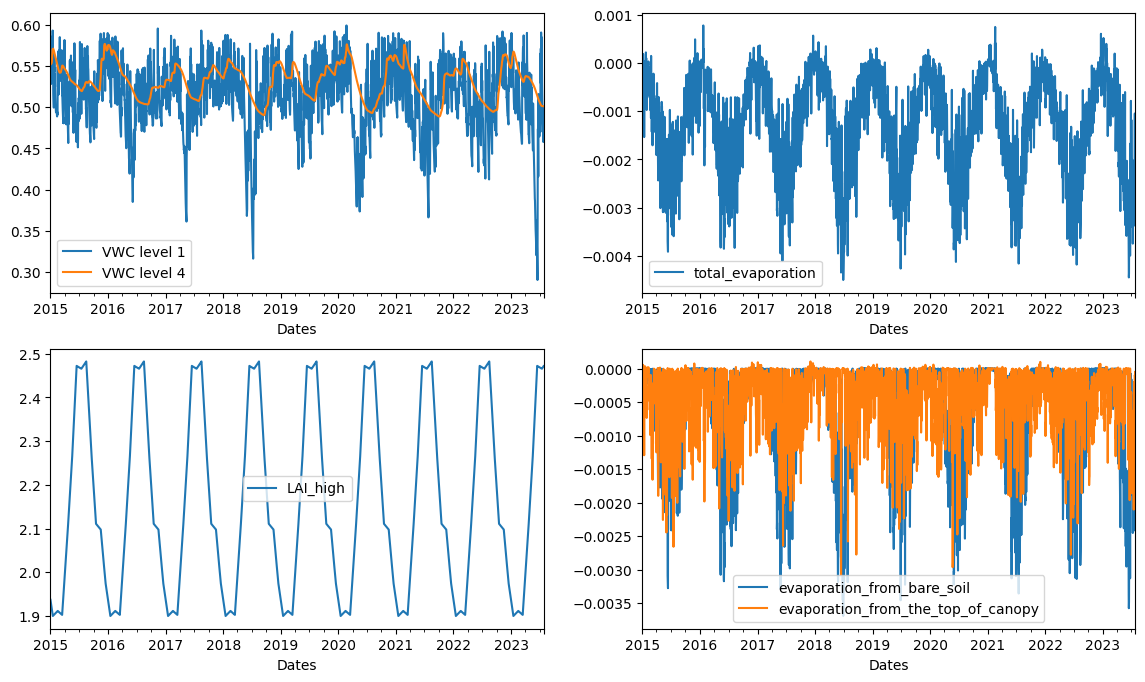

In [80]:
df_1 = df_ERA5_peatlands_dataset[df_ERA5_peatlands_dataset['Site']=='Flanders Moss']
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2,ncols=2,figsize=(14,8))
df_1['VSWC1'].plot(ax=ax1,label='VWC level 1')
df_1['VSWC4'].plot(ax=ax1,label='VWC level 4')
df_1['total_evaporation'].plot(ax=ax2,label='total_evaporation')
df_1['LAI_high'].plot(ax=ax3,label='LAI_high')
df_1['evaporation_from_bare_soil'].plot(ax=ax4,label='evaporation_from_bare_soil')
df_1['evaporation_from_the_top_of_canopy'].plot(ax=ax4,label='evaporation_from_the_top_of_canopy')
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()

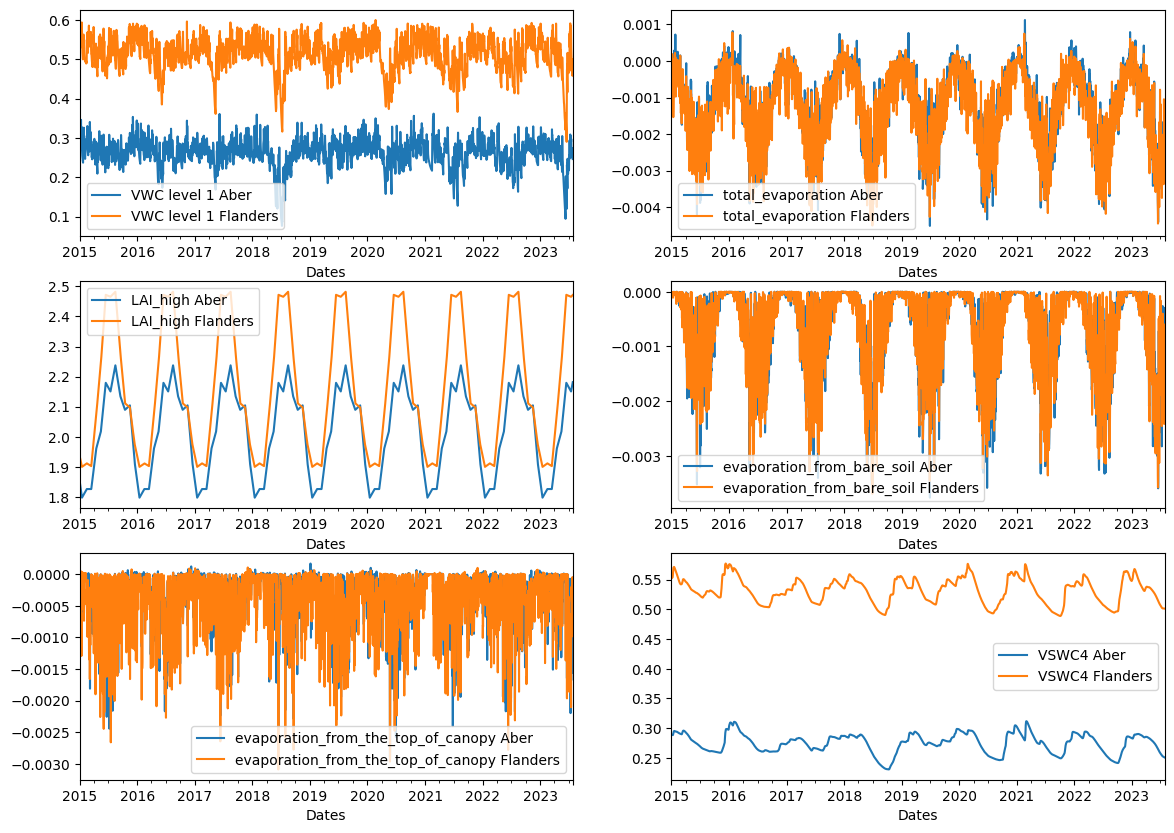

In [83]:

fig,((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(nrows=3,ncols=2,figsize=(14,10))
df_['VSWC1'].plot(ax=ax1,label='VWC level 1 Aber')
df_1['VSWC1'].plot(ax=ax1,label='VWC level 1 Flanders')
df_['total_evaporation'].plot(ax=ax2,label='total_evaporation Aber')
df_1['total_evaporation'].plot(ax=ax2,label='total_evaporation Flanders')
df_['LAI_high'].plot(ax=ax3,label='LAI_high Aber')
df_1['LAI_high'].plot(ax=ax3,label='LAI_high Flanders')
df_['evaporation_from_bare_soil'].plot(ax=ax4,label='evaporation_from_bare_soil Aber')
df_1['evaporation_from_bare_soil'].plot(ax=ax4,label='evaporation_from_bare_soil Flanders')
df_['evaporation_from_the_top_of_canopy'].plot(ax=ax5,label='evaporation_from_the_top_of_canopy Aber')
df_1['evaporation_from_the_top_of_canopy'].plot(ax=ax5,label='evaporation_from_the_top_of_canopy Flanders')
df_['VSWC4'].plot(ax=ax6,label='VSWC4 Aber')
df_1['VSWC4'].plot(ax=ax6,label='VSWC4 Flanders')
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
ax5.legend()
ax6.legend()